In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

import seaborn as sns

import torch

In [2]:
# Create dataset 

points, labels = make_moons(n_samples=1500, shuffle=True, random_state=0, noise=0.3)

In [45]:
points

array([[-0.29987271,  1.04851   ],
       [ 0.60495895,  0.73412765],
       [ 2.28985314,  0.48902957],
       ...,
       [ 1.47292959, -0.5036515 ],
       [-0.41981617,  1.04180854],
       [-0.586359  , -0.17273211]])

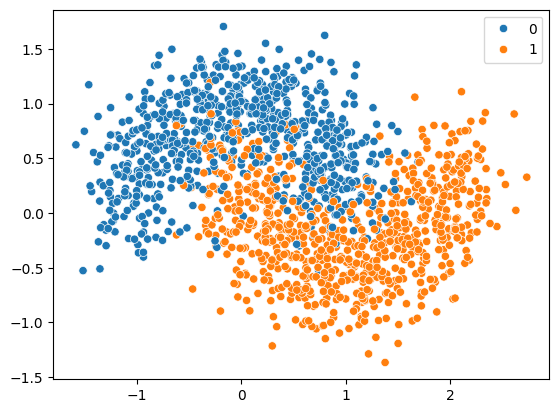

In [3]:
sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker='o'
)
plt.show()

In [5]:
# train / dev / test 
from sklearn.model_selection import train_test_split

# split 70/15/15
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)


In [7]:
X_train.shape, X_val.shape, X_test.shape

((1050, 2), (225, 2), (225, 2))

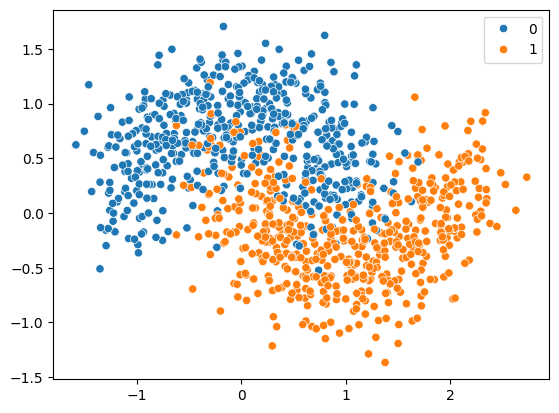

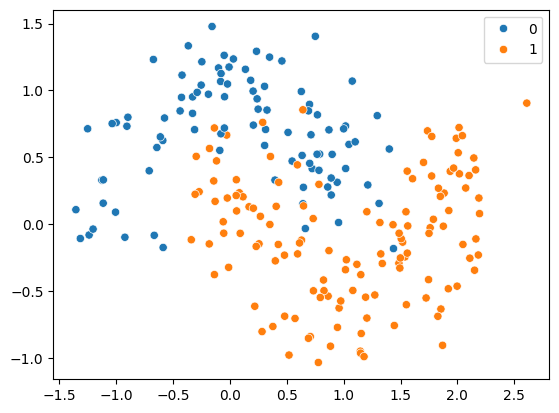

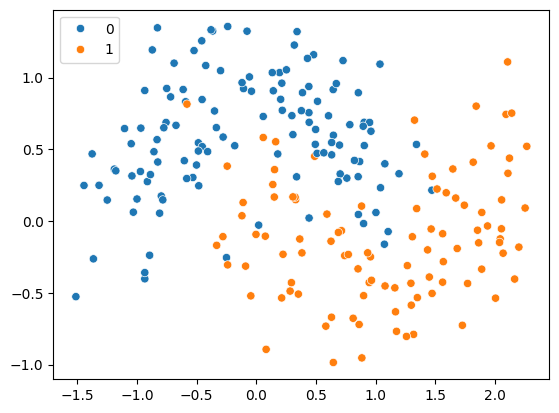

In [8]:
sns.scatterplot(
    x=X_train[:, 0], y=X_train[:, 1], hue=y_train, marker='o'
)
plt.show()
sns.scatterplot(
    x=X_val[:, 0], y=X_val[:, 1], hue=y_val, marker='o'
)
plt.show()
sns.scatterplot(
    x=X_test[:, 0], y=X_test[:, 1], hue=y_test, marker='o'
)
plt.show()

In [11]:
tX_train = torch.from_numpy(X_train).to(dtype=torch.float32)
tX_val = torch.from_numpy(X_val).to(dtype=torch.float32)
tX_test = torch.from_numpy(X_test).to(dtype=torch.float32)

ty_train = torch.from_numpy(y_train).to(dtype=torch.float32)
ty_val = torch.from_numpy(y_val).to(dtype=torch.float32)
ty_test = torch.from_numpy(y_test).to(dtype=torch.float32)

In [129]:
torch.manual_seed(0)

W1 = torch.randn((tX_train.shape[1], 5)) * (5/3) / (tX_train.shape[1] ** (0.5))
# b1 = torch.randn((5)) * 0

W2 = torch.randn(W1.shape[1], 1) * (5/3) / (W1.shape[1] ** (0.5))
b2 = torch.randn((1)) * 0

gamma = torch.ones((1, W1.shape[1]))
beta = torch.zeros((1, W1.shape[1]))

running_mean = torch.zeros((1,  W1.shape[1]))
running_std = torch.ones((1,  W1.shape[1]))

K_mean = 0.999
# momentum = 1 - K_mean
K_std = 0.999
# momentum = 1 - K_std

# x @ w 

parameters = [W1, W2, b2, gamma, beta,]# b1,]
print(parameters)

for p in parameters:
    p.requires_grad = True

train_loss = []
val_loss = []

num_steps = 1000
batch_size = 32

learning_rate = 10 ** (-1.5)
# 1e-4 1e-6 2e-5
# 1e-2.435645
lrs = torch.linspace(-3, 0, 1000)
lre = 10 ** lrs

for i in range(num_steps):
# for i in range(len(lre)):
    # batches selection
    ix = torch.randint(0, tX_train.shape[0], (batch_size, ))
    # 0 1 2 3 4
    # 0 5 6 7 8
    batchX, batchy = tX_train[ix], ty_train[ix]

    # forward pass
    h_preact = batchX @ W1 #+ b1

    bnmean_i = h_preact.mean(dim=0, keepdims=True)
    bnstd_i = h_preact.std(dim=0, keepdims=True)
    h_preact = gamma * ((h_preact - bnmean_i) / (1e-5+ bnstd_i)) + beta

    with torch.no_grad():
        running_mean = K_mean * running_mean + (1. - K_mean) * bnmean_i
        running_std = K_std * running_std + (1. - K_std) * bnstd_i
    
    h = torch.tanh(h_preact)
    logit = h @ W2 + b2

    # plt.hist(h.flatten().tolist(), 25)
    # plt.show()
    # plt.hist(h_preact.flatten().tolist(), 25)
    # plt.show()

    # sns.heatmap(h.abs() > 0.9)
    # plt.show()


    # loss calculation
    # https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logit.squeeze(1), batchy)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # storing the results
    train_loss.append(loss.item())

    # update
    # learning_rate = lre[i]
    for p in parameters:
        p.data += -learning_rate * p.grad

    # validation
    with torch.no_grad():
        h_preact_train = tX_train @ W1 #+ b1
        h_preact = tX_val @ W1 #+ b1
    
        bnmean_i = h_preact_train.mean(dim=0, keepdims=True)
        bnstd_i = h_preact_train.std(dim=0, keepdims=True)
        
        # h_preact = gamma * ((h_preact - bnmean_i) / bnstd_i) + beta
        h_preact  = gamma * ((h_preact - running_mean) / running_std) + beta
        
        h = torch.tanh(h_preact)
        logit = h @ W2 + b2
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit.squeeze(1), ty_val)
        val_loss.append(loss.item())

# test
with torch.no_grad():
    h_preact_train = tX_train @ W1 #+ b1
    h_preact = tX_test @ W1 #+ b1
    bnmean_i = h_preact_train.mean(dim=0, keepdims=True)
    bnstd_i = h_preact_train.std(dim=0, keepdims=True)
    # h_preact = gamma * ((h_preact - bnmean_i) / bnstd_i) + beta
    h_preact  = gamma * ((h_preact - running_mean) / running_std) + beta
    h = torch.tanh(h_preact)
    logit = h @ W2 + b2
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logit.squeeze(1), ty_test)
    print('Val error: ', val_loss[-1])
    print('Test error: ', loss.item())

[tensor([[ 1.8161, -0.3458, -2.5677,  0.6699, -1.2781],
        [-1.6483,  0.4753,  0.9876, -0.8477, -0.4753]]), tensor([[-0.4447],
        [ 0.1357],
        [-0.6385],
        [ 0.8203],
        [-0.7984]]), tensor([0.]), tensor([[1., 1., 1., 1., 1.]]), tensor([[0., 0., 0., 0., 0.]])]
Val error:  0.37521257996559143
Test error:  0.3230612874031067


In [130]:
gamma, beta

(tensor([[0.9656, 1.0566, 0.7755, 1.2935, 0.5599]], requires_grad=True),
 tensor([[ 0.0100,  0.0275, -0.0008, -0.1561, -0.0336]], requires_grad=True))

In [125]:
h_preact_train = tX_train @ W1 + b1

bnmean_i = h_preact_train.mean(dim=0, keepdims=True)
bnstd_i = h_preact_train.std(dim=0, keepdims=True)




In [126]:
running_mean, bnmean_i

(tensor([[ 0.2481,  0.0842, -0.6395,  0.1225, -0.3749]]),
 tensor([[ 0.3309,  0.1097, -0.9939,  0.1871, -0.5312]],
        grad_fn=<MeanBackward1>))

In [127]:
running_std, bnstd_i

(tensor([[1.7315, 0.5966, 2.0133, 0.9756, 1.1699]]),
 tensor([[2.1301, 0.3917, 2.6004, 0.9606, 1.2883]], grad_fn=<StdBackward0>))

tensor(-0.0119) tensor(1.0046)
tensor(0.1204) tensor(0.1825)


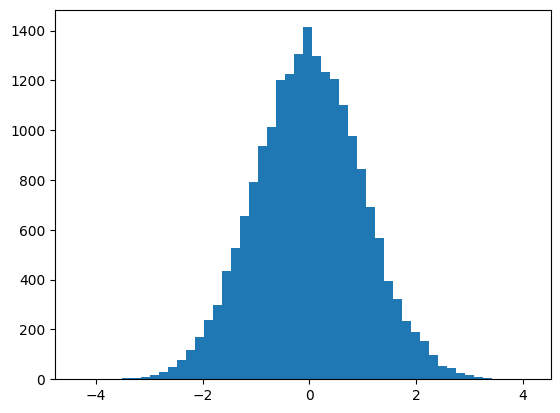

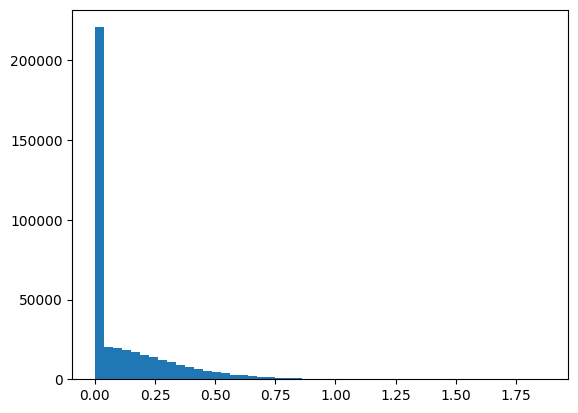

In [104]:
torch.manual_seed(0)

x = torch.randn(2000, 10) 
w = torch.randn(10, 200) * (2 ** (0.5)) / (10 ** (0.5)) # fan_in
# w = torch.randn(10, 200) * (2 ** (0.5)) / (200 ** (0.5)) # fan_out

y = (x @ w).relu()

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.hist(x.flatten().tolist(), 50)
plt.show()
plt.hist(y.flatten().tolist(), 50)
plt.show()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
parameters

[tensor([[ 0.9289, -0.1603, -2.1727,  0.4991, -1.4028],
         [-1.8568,  1.3222,  0.7732, -0.2272,  0.1726]], requires_grad=True),
 tensor([-0.7019, -0.0880, -0.9156,  1.4458, -1.1630], requires_grad=True),
 tensor([[ 1.3185],
         [-1.7092],
         [-0.0780],
         [-0.8249],
         [-1.4895]], requires_grad=True),
 tensor([0.1773], requires_grad=True)]

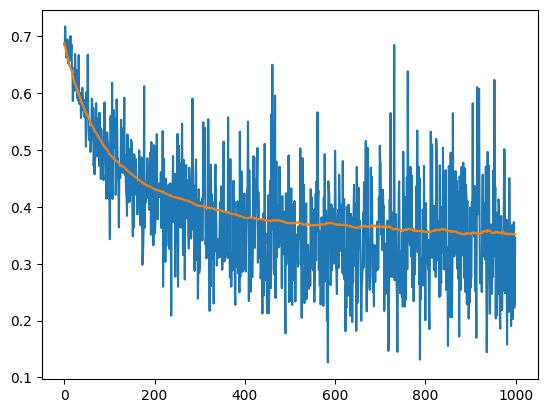

In [94]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

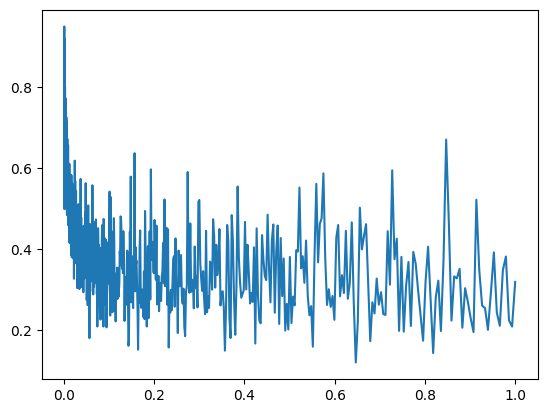

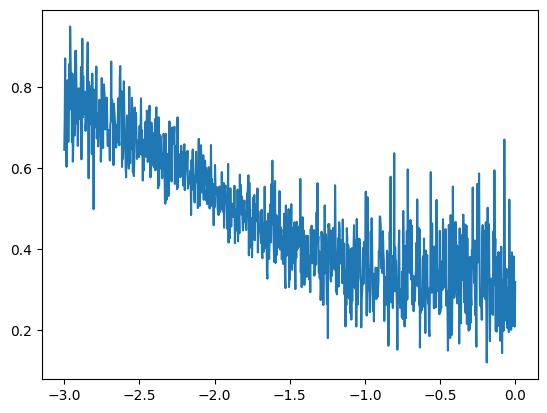

In [75]:
plt.plot(lre, train_loss)
plt.show()
plt.plot(lrs, train_loss)
plt.show()

In [108]:
# STATISTICS AND RESULTS

# v1 : initial guess
# Val error:  0.5534049868583679
# Test error:  0.5643410086631775

# v1.1 : find learning rate
# Val error:  0.3457016944885254
# Test error:  0.30866748094558716

# v2 : dummy init
# Val error:  0.3518730103969574
# Test error:  0.3126732409000397

# v2 : fan_in init
# Val error:  0.354238361120224
# Test error:  0.31430959701538086